<a href="https://colab.research.google.com/github/allenphos/Study-projects/blob/main/Imbalanced_Multi_class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation using Machine Learning

##Handling an Imbalanced Multi-Class Classification Problem
This project focuses on customer segmentation, an essential strategy in marketing where customers are grouped based on their similarities. The goal is to predict customer segments based on given features using Logistic Regression while addressing the imbalance in the dataset through SMOTE and SMOTE-Tomek techniques.


## About Dataset
**Context**

Customer segmentation is the practice of dividing a customer base into groups of individuals that are similar in specific ways relevant to marketing, such as age, gender, interests and spending habits.

Companies employing customer segmentation operate under the fact that every customer is different and that their marketing efforts would be better served if they target specific, smaller groups with messages that those consumers would find relevant and lead them to buy something. Companies also hope to gain a deeper understanding of their customers' preferences and needs with the idea of discovering what each segment finds most valuable to more accurately tailor marketing materials toward that segment.

**Content**

An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4 and P5). After intensive market research, they’ve deduced that the behavior of new market is similar to their existing market.

In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them. They plan to use the same strategy on new markets and have identified 2627 new potential customers.

You are required to help the manager to predict the right group of the new customers.

In this assignment, were used the [customer_segmentation_train.csv ](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view) data. It is the train.csv file from [this](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data) competition.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



**Key Steps in Data Processing:**

*   Handle missing values
*   Encode categorical features
*   Split data into training & validation sets
*   Apply SMOTENC and SMOTE-Tomek to address class imbalance


## 1. Implementation


### 1.1 Import Required Libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

### 1.2 Load & Explore the Dataset

In [15]:
# Download the dataset
raw_df = pd.read_csv('drive/MyDrive/Colab Notebooks/data/customer_segmentation_train.csv')

raw_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [16]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [17]:
raw_df.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [18]:
# Check for missing values
raw_df.isna().sum()

,0
ID,0
Gender,0
Ever_Married,140
Age,0
Graduated,78
Profession,124
Work_Experience,829
Spending_Score,0
Family_Size,335
Var_1,76


<ipython-input-19-a8928ec90453>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=raw_df['Segmentation'], palette="viridis")


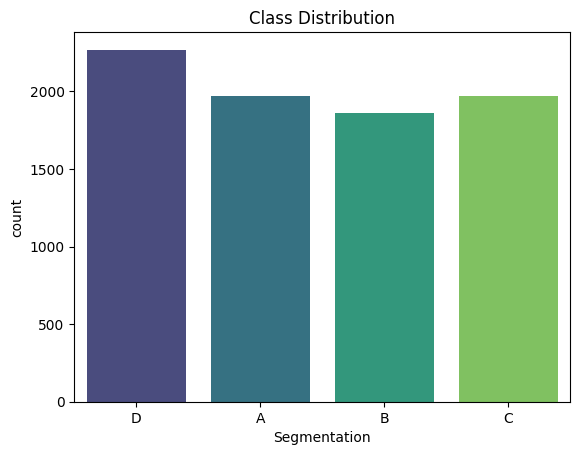

In [19]:
# Visualizing Class Distribution
sns.countplot(x=raw_df['Segmentation'], palette="viridis")
plt.title("Class Distribution")
plt.show()

### 1.3 Data Preprocessing



In [20]:
# Create inputs and targets
input_cols = raw_df.drop(columns=['Segmentation'])
target_col = raw_df['Segmentation']

# Identify numeric and categorical columns
numeric_cols = input_cols.select_dtypes(include=np.number).columns.tolist()
categorical_cols = input_cols.select_dtypes('object').columns.tolist()

In [24]:
# Missing Data Analysis
null_count = input_cols.isnull().sum()
null_percentage = round((input_cols.isnull().sum() / input_cols.shape[0]) * 100, 2)

# Creating a DataFrame to Summarize Missing Data
null_df = pd.DataFrame({
    'column_name': input_cols.columns,
    'null_count': null_count,
    'null_percentage': null_percentage
})

null_df.reset_index(drop=True, inplace=True)  # Resetting the Index

# Sorting by null_percentage in descending order
null_df_sorted = null_df.sort_values(by='null_percentage', ascending=False)

null_df_sorted

,column_name,null_count,null_percentage
6,Work_Experience,829,10.28
8,Family_Size,335,4.15
2,Ever_Married,140,1.74
5,Profession,124,1.54
4,Graduated,78,0.97
9,Var_1,76,0.94
0,ID,0,0.00
1,Gender,0,0.00
3,Age,0,0.00
7,Spending_Score,0,0.00


In [25]:
# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# inputs_train inputs_test targets_train targets_test
X_train_raw, X_val_raw, y_train, y_val = train_test_split(input_cols, target_col, test_size=0.2,stratify=target_col, random_state=42)

# Fit and transform the training data
X_train = preprocessor.fit_transform(X_train_raw)

# Transform the validation data (based on the training fit)
X_val = preprocessor.transform(X_val_raw)


In [26]:
# Displaying the transformed datasets
pd.set_option('display.max_columns', None)
display(pd.DataFrame(X_train).head()), display(pd.DataFrame(X_val).head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.931296,-0.695320,1.942754,-1.227022,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.220807,1.703982,0.000000,-0.560068,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.697318,-0.635337,-0.513120,0.773838,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.051676,0.264401,-0.820105,2.107745,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.389029,-0.935250,1.942754,-1.227022,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,-0.341697,-0.155477,2.863707,0.106885,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.424336,-1.355128,0.407832,0.773838,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.001286,-0.455390,-0.820105,-1.227022,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.965069,-0.995233,-0.820105,-0.560068,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.712554,-1.535076,-0.820105,2.107745,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


(None, None)

In [27]:
print("Size:", X_train.shape, y_train.shape)


Size: (6454, 33) (6454,)


In [28]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))  # Checking the class distribution

{'A': 1578, 'B': 1486, 'C': 1576, 'D': 1814}


## 2. Handling Class Imbalance

### 2.1 Using SMOTENC (for Categorical Data)

In [32]:
from imblearn.over_sampling import SMOTENC

# Identify categorical feature indices
cat_feature_indices = list(range(len(numeric_cols), X_train.shape[1]))

# Apply SMOTENC
smotenc = SMOTENC(categorical_features=cat_feature_indices, random_state=42)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train, y_train)

print("After SMOTENC:", X_train_smotenc.shape, y_train_smotenc.shape)

After SMOTENC: (7256, 33) (7256,)


In [33]:
unique, counts = np.unique(y_train_smotenc, return_counts=True)
print(dict(zip(unique, counts)))  # Checking the class distribution

{'A': 1814, 'B': 1814, 'C': 1814, 'D': 1814}


### 2️.2 Using SMOTE-Tomek (for More Balance)

In [41]:
from imblearn.combine import SMOTETomek

# Apply SMOTE-Tomek
smote_tomek = SMOTETomek(random_state=42)
X_train_smotetomek, y_train_smotetomek = smote_tomek.fit_resample(X_train_smotenc, y_train_smotenc)

print("After SMOTE-Tomek:", X_train_smotetomek.shape, y_train_smotetomek.shape)


After SMOTE-Tomek: (5712, 33) (5712,)


In [42]:
unique, counts = np.unique(y_train_smotetomek, return_counts=True)
print(dict(zip(unique, counts)))  # Checking the class distribution

{'A': 1408, 'B': 1398, 'C': 1415, 'D': 1491}


## 3. Model Training & Evaluation

### 3.1 Train Logistic Regression using One-vs-Rest (OvR) Strategy

### Original Data

In [43]:
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier

# Logistic Regression with One-vs-Rest (OvR) strategy
log_reg = LogisticRegression(solver='liblinear')
ovr_model = OneVsRestClassifier(log_reg)
ovr_model.fit(X_train, y_train)
ovr_predictions = ovr_model.predict(X_val)

# Calculate precision and recall metrics for each class
print(classification_report(y_val, ovr_predictions))

              precision    recall  f1-score   support

           A       0.43      0.47      0.45       394
           B       0.41      0.17      0.24       372
           C       0.49      0.62      0.55       394
           D       0.65      0.76      0.70       454

    accuracy                           0.52      1614
   macro avg       0.49      0.50      0.48      1614
weighted avg       0.50      0.52      0.49      1614



In [44]:
ovr_model.classes_

array(['A', 'B', 'C', 'D'], dtype='<U1')

In [45]:
roc_auc = roc_auc_score(y_val, ovr_model.predict_proba(X_val), multi_class='ovr')
print(f"Multi-class ROC AUC: {roc_auc:.4f}")

Multi-class ROC AUC: 0.7688


### SMOTENC

In [46]:
ovr_model_smnc = OneVsRestClassifier(log_reg)
ovr_model_smnc.fit(X_train_smotenc, y_train_smotenc)
ovr_predictions_smnc = ovr_model_smnc.predict(X_val)

# precision and recall metrics for each class
print(classification_report(y_val, ovr_predictions_smnc))

              precision    recall  f1-score   support

           A       0.42      0.46      0.44       394
           B       0.39      0.23      0.29       372
           C       0.50      0.59      0.54       394
           D       0.66      0.72      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614



In [47]:
roc_auc = roc_auc_score(y_val, ovr_model_smnc.predict_proba(X_val), multi_class='ovr')
print(f"Multi-class ROC AUC: {roc_auc:.4f}")

Multi-class ROC AUC: 0.7672


### SMOTE-Tomek

In [48]:
ovr_model_smt = OneVsRestClassifier(log_reg)
ovr_model_smt.fit(X_train_smotetomek, y_train_smotetomek)
ovr_predictions_smt = ovr_model_smt.predict(X_val)

# precision and recall metrics for each class
print(classification_report(y_val, ovr_predictions_smt))

              precision    recall  f1-score   support

           A       0.42      0.47      0.44       394
           B       0.39      0.25      0.30       372
           C       0.51      0.59      0.55       394
           D       0.67      0.71      0.69       454

    accuracy                           0.51      1614
   macro avg       0.50      0.50      0.50      1614
weighted avg       0.50      0.51      0.50      1614



In [49]:
roc_auc = roc_auc_score(y_val, ovr_model_smt.predict_proba(X_val), multi_class='ovr')
print(f"Multi-class ROC AUC: {roc_auc:.4f}")

Multi-class ROC AUC: 0.7680


Since the task is multi-class, it is necessary to use roc_auc_score with multi_class='ovr'.
- On original data with OvR ROC AUC: 0.7688
- SMOTENC Multi-class ROC AUC: 0.7672
- SMOTE-Tomek Multi-class ROC AUC: 0.7680

Data without balancing shows the best result.
If we look at the f1-score, class D has the best prediction quality at 70%, then C - 55%, A - 44%, and the lowest quality is in class B - 24-30%. This is consistent with the class distribution in the original data.

According to the macro avg and weighted avg metrics, the best result is shown by the model with SMOTE-Tomek balancing - 50%. This means that balancing slightly improved the accuracy on classes with a smaller amount of data, but did not increase the overall accuracy of the model.

**Conclusion**: Group D is the most suitable for classifying new customers.
